In [1]:
import os
import sys
home_dir = "../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from utility.data_utils import get_uniform_peaks_metadata, compute_multi_class_weights
import utility.pickle_utils as pickle_utils

In [2]:
peaks_metadata_df = get_uniform_peaks_metadata(home_dir)
# peaks_metadata_df

(690, 18)
Index(['filename', 'project', 'lab', 'composite', 'dataType', 'view', 'cell',
       'treatment', 'antibody', 'control', 'dataVersion', 'dccAccession',
       'controlId', 'quality', 'tableName', 'type', 'md5sum', 'size'],
      dtype='object')


In [3]:
# computing number of examples per label in test set
data_path = home_dir + "data/train_val_test/peaks_with_labels_test.tsv.gz"
data_df = pd.read_csv(data_path, compression="gzip", sep="\t")
labels_dict = pickle_utils.load(
    home_dir + "data/processed/peakfilename_index_dict.pkl"
)

all_labels = []
def get_all_labels(labels):
    for l in labels.split(","):
        l = l.strip()
        all_labels.append(labels_dict[l])

data_df["labels"].apply(get_all_labels)
print(len(all_labels))

from collections import Counter
c = Counter(all_labels)  # returns a Counter, dict-like object
len(c)

index2label_dict = {i:label for label, i in labels_dict.items()}
label2count_dict = {index2label_dict[i]:count for i, count in c.items()}
label2count_dict

label2count_df = pd.DataFrame.from_dict(label2count_dict, orient="index")
label2count_df.reset_index(inplace=True)
label2count_df.rename(columns={0:"labels_count"}, inplace=True)
label2count_df

1550288


,index,labels_count
0,wgEncodeAwgTfbsHaibA549Ctcfsc5916Pcr1xEtoh02UniPk,3089
1,wgEncodeAwgTfbsUwHbmecCtcfUniPk,6133
2,wgEncodeAwgTfbsUwGm12873CtcfUniPk,5380
3,wgEncodeAwgTfbsUwBe2cCtcfUniPk,6573
4,wgEncodeAwgTfbsUtaGm19238CtcfUniPk,3873
...,...,...
685,wgEncodeAwgTfbsSydhK562NelfeUniPk,58
686,wgEncodeAwgTfbsSydhHelas3Brf2UniPk,26
687,wgEncodeAwgTfbsSydhK562Pol3UniPk,14
688,wgEncodeAwgTfbsSydhK562Brf1UniPk,6


In [4]:
# https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/
# this link contains a very good discussion of baseline aupr value for biased dataset
n_labels = label2count_df["labels_count"].sum()
label2count_df["baseline_aupr"] = label2count_df["labels_count"] / n_labels  
label2count_df

,index,labels_count,baseline_aupr
0,wgEncodeAwgTfbsHaibA549Ctcfsc5916Pcr1xEtoh02UniPk,3089,0.001993
1,wgEncodeAwgTfbsUwHbmecCtcfUniPk,6133,0.003956
2,wgEncodeAwgTfbsUwGm12873CtcfUniPk,5380,0.003470
3,wgEncodeAwgTfbsUwBe2cCtcfUniPk,6573,0.004240
4,wgEncodeAwgTfbsUtaGm19238CtcfUniPk,3873,0.002498
...,...,...,...
685,wgEncodeAwgTfbsSydhK562NelfeUniPk,58,0.000037
686,wgEncodeAwgTfbsSydhHelas3Brf2UniPk,26,0.000017
687,wgEncodeAwgTfbsSydhK562Pol3UniPk,14,0.000009
688,wgEncodeAwgTfbsSydhK562Brf1UniPk,6,0.000004


In [5]:
peaks_metadata_df = peaks_metadata_df.merge(label2count_df, left_on="tableName", right_on="index", how="inner")

In [6]:
# computing the class weights from train set
index2clsweights = compute_multi_class_weights(home_dir)
index2clsweights = np.array(index2clsweights)
label2clsweights_dict = {label:index2clsweights[i] for i, label in index2label_dict.items()}
label2clsweights_dict

label2clsweights_df = pd.DataFrame.from_dict(label2clsweights_dict, orient="index")
label2clsweights_df.reset_index(inplace=True)
label2clsweights_df.rename(columns={0:"cls_weights"}, inplace=True)
label2clsweights_df

,index,cls_weights
0,wgEncodeAwgTfbsBroadDnd41CtcfUniPk,0.411326
1,wgEncodeAwgTfbsBroadDnd41Ezh239875UniPk,7.080133
2,wgEncodeAwgTfbsBroadGm12878CtcfUniPk,0.380523
3,wgEncodeAwgTfbsBroadGm12878Ezh239875UniPk,6.967915
4,wgEncodeAwgTfbsBroadH1hescChd1a301218aUniPk,1.346780
...,...,...
685,wgEncodeAwgTfbsUwRptecCtcfUniPk,0.344163
686,wgEncodeAwgTfbsUwSaecCtcfUniPk,0.569133
687,wgEncodeAwgTfbsUwSknshraCtcfUniPk,0.620629
688,wgEncodeAwgTfbsUwWerirb1CtcfUniPk,0.550039


In [7]:
peaks_metadata_df = peaks_metadata_df.merge(label2clsweights_df, on="index", how="inner")

In [8]:
# reading multiple models performance in test set
model_name = "dnabert2_epbd_crossattn_bestmodel"
dnabert2_perf_df = pd.read_csv(home_dir+"analysis/aurocs_auprs/dnabert2_on_test.tsv", sep="\t")
dnabert2_epbd_crossattn_perf_df = pd.read_csv(home_dir+f"analysis/aurocs_auprs/{model_name}_on_test.tsv", sep="\t")
dnabert2_randepbd_crossattn_perf_df = pd.read_csv(home_dir+"analysis/aurocs_auprs/dnabert2_randepbd_crossattn_on_test.tsv", sep="\t")

In [9]:
# merging more than 2 dfs
dfs = [dnabert2_perf_df, dnabert2_epbd_crossattn_perf_df, dnabert2_randepbd_crossattn_perf_df]
from functools import reduce
merged_df = reduce(lambda  left, right: pd.merge(left, right, on=["index", "cell", "antibody"], how='inner'), dfs)
merged_df

,index,cell,antibody,dnabert2_auroc,dnabert2_aupr,dnabert2_epbd_crossattn_bestmodel_auroc,dnabert2_epbd_crossattn_bestmodel_aupr,dnabert2_randepbd_crossattn_auroc,dnabert2_randepbd_crossattn_aupr
0,wgEncodeAwgTfbsBroadDnd41CtcfUniPk,Dnd41,CTCF,0.95692,0.61092,0.96012,0.62702,0.95317,0.60418
1,wgEncodeAwgTfbsBroadDnd41Ezh239875UniPk,Dnd41,EZH2_(39875),0.92707,0.03926,0.93142,0.05153,0.92418,0.03757
2,wgEncodeAwgTfbsBroadGm12878CtcfUniPk,GM12878,CTCF,0.95075,0.58643,0.95550,0.59429,0.94735,0.57417
3,wgEncodeAwgTfbsBroadGm12878Ezh239875UniPk,GM12878,EZH2_(39875),0.86375,0.03159,0.89687,0.03262,0.88792,0.03151
4,wgEncodeAwgTfbsBroadH1hescChd1a301218aUniPk,H1-hESC,CHD1_(A301-218A),0.92241,0.15572,0.93621,0.17676,0.91737,0.14103
...,...,...,...,...,...,...,...,...,...
685,wgEncodeAwgTfbsUwRptecCtcfUniPk,RPTEC,CTCF,0.94735,0.62568,0.95302,0.63848,0.94337,0.61897
686,wgEncodeAwgTfbsUwSaecCtcfUniPk,SAEC,CTCF,0.96643,0.59766,0.96834,0.61293,0.96298,0.58886
687,wgEncodeAwgTfbsUwSknshraCtcfUniPk,SK-N-SH_RA,CTCF,0.97116,0.58857,0.97375,0.60473,0.96791,0.57786
688,wgEncodeAwgTfbsUwWerirb1CtcfUniPk,WERI-Rb-1,CTCF,0.96524,0.54944,0.96852,0.56766,0.96330,0.54369


In [10]:
result_df = peaks_metadata_df.merge(merged_df, on=["index", "cell", "antibody"], how="inner")
result_df

,filename,project,lab,composite,dataType,view,cell,treatment,antibody,control,...,index,labels_count,baseline_aupr,cls_weights,dnabert2_auroc,dnabert2_aupr,dnabert2_epbd_crossattn_bestmodel_auroc,dnabert2_epbd_crossattn_bestmodel_aupr,dnabert2_randepbd_crossattn_auroc,dnabert2_randepbd_crossattn_aupr
0,wgEncodeAwgTfbsBroadDnd41CtcfUniPk.narrowPeak.gz,wgEncode,Broad,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,Dnd41,None,CTCF,std,...,wgEncodeAwgTfbsBroadDnd41CtcfUniPk,5099,0.003289,0.411326,0.95692,0.61092,0.96012,0.62702,0.95317,0.60418
1,wgEncodeAwgTfbsBroadDnd41Ezh239875UniPk.narrow...,wgEncode,Broad,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,Dnd41,None,EZH2_(39875),std,...,wgEncodeAwgTfbsBroadDnd41Ezh239875UniPk,320,0.000206,7.080133,0.92707,0.03926,0.93142,0.05153,0.92418,0.03757
2,wgEncodeAwgTfbsBroadGm12878CtcfUniPk.narrowPea...,wgEncode,Broad,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,GM12878,None,CTCF,std,...,wgEncodeAwgTfbsBroadGm12878CtcfUniPk,6073,0.003917,0.380523,0.95075,0.58643,0.95550,0.59429,0.94735,0.57417
3,wgEncodeAwgTfbsBroadGm12878Ezh239875UniPk.narr...,wgEncode,Broad,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,GM12878,None,EZH2_(39875),std,...,wgEncodeAwgTfbsBroadGm12878Ezh239875UniPk,328,0.000212,6.967915,0.86375,0.03159,0.89687,0.03262,0.88792,0.03151
4,wgEncodeAwgTfbsBroadH1hescChd1a301218aUniPk.na...,wgEncode,Broad,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,H1-hESC,None,CHD1_(A301-218A),std,...,wgEncodeAwgTfbsBroadH1hescChd1a301218aUniPk,1528,0.000986,1.346780,0.92241,0.15572,0.93621,0.17676,0.91737,0.14103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,wgEncodeAwgTfbsUwRptecCtcfUniPk.narrowPeak.gz,wgEncode,UW,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,RPTEC,None,CTCF,std,...,wgEncodeAwgTfbsUwRptecCtcfUniPk,6997,0.004513,0.344163,0.94735,0.62568,0.95302,0.63848,0.94337,0.61897
686,wgEncodeAwgTfbsUwSaecCtcfUniPk.narrowPeak.gz,wgEncode,UW,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,SAEC,None,CTCF,std,...,wgEncodeAwgTfbsUwSaecCtcfUniPk,4192,0.002704,0.569133,0.96643,0.59766,0.96834,0.61293,0.96298,0.58886
687,wgEncodeAwgTfbsUwSknshraCtcfUniPk.narrowPeak.gz,wgEncode,UW,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,SK-N-SH_RA,None,CTCF,std,...,wgEncodeAwgTfbsUwSknshraCtcfUniPk,3811,0.002458,0.620629,0.97116,0.58857,0.97375,0.60473,0.96791,0.57786
688,wgEncodeAwgTfbsUwWerirb1CtcfUniPk.narrowPeak.gz,wgEncode,UW,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,WERI-Rb-1,None,CTCF,std,...,wgEncodeAwgTfbsUwWerirb1CtcfUniPk,4397,0.002836,0.550039,0.96524,0.54944,0.96852,0.56766,0.96330,0.54369


In [11]:
# improvements on AUROC and AUPR in percentage and relative 
result_df["auroc_dnabert2epbdVSdnabert2_percent"] = 100 *( (result_df[f"{model_name}_auroc"] - result_df["dnabert2_auroc"]) / result_df["dnabert2_auroc"])
result_df["auroc_dnabert2epbdVSdnabert2_relative"] = result_df[f"{model_name}_auroc"] - result_df["dnabert2_auroc"]
result_df["aupr_dnabert2epbdVSdnabert2_percent"] = 100 *( (result_df[f"{model_name}_aupr"] - result_df["dnabert2_aupr"]) / result_df["dnabert2_aupr"])
result_df["aupr_dnabert2epbdVSdnabert2_relative"] = result_df[f"{model_name}_aupr"] - result_df["dnabert2_aupr"]

result_df["auroc_dnabert2randepbdVSdnabert2_percent"] = 100 *( (result_df["dnabert2_randepbd_crossattn_auroc"] - result_df["dnabert2_auroc"]) / result_df["dnabert2_auroc"])
result_df["auroc_dnabert2randepbdVSdnabert2_relative"] = result_df["dnabert2_randepbd_crossattn_auroc"] - result_df["dnabert2_auroc"]
result_df["aupr_dnabert2randepbdVSdnabert2_percent"] = 100 *( (result_df["dnabert2_randepbd_crossattn_aupr"] - result_df["dnabert2_aupr"]) / result_df["dnabert2_aupr"])
result_df["aupr_dnabert2randepbdVSdnabert2_relative"] = result_df["dnabert2_randepbd_crossattn_aupr"] - result_df["dnabert2_aupr"]

result_df.sort_values(by="auroc_dnabert2epbdVSdnabert2_percent", ascending=False, inplace=True)
result_df.head(10)

,filename,project,lab,composite,dataType,view,cell,treatment,antibody,control,...,dnabert2_randepbd_crossattn_auroc,dnabert2_randepbd_crossattn_aupr,auroc_dnabert2epbdVSdnabert2_percent,auroc_dnabert2epbdVSdnabert2_relative,aupr_dnabert2epbdVSdnabert2_percent,aupr_dnabert2epbdVSdnabert2_relative,auroc_dnabert2randepbdVSdnabert2_percent,auroc_dnabert2randepbdVSdnabert2_relative,aupr_dnabert2randepbdVSdnabert2_percent,aupr_dnabert2randepbdVSdnabert2_relative
438,wgEncodeAwgTfbsSydhHepg2Mafksc477IggrabUniPk.n...,wgEncode,Stanford,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,HepG2,None,MafK_(SC-477),IgG-rab,...,0.85703,0.29293,9.631457,0.08551,73.820899,0.24104,-3.468045,-0.03079,-10.287272,-0.03359
268,wgEncodeAwgTfbsHaibT47dEraaV0416102Bpa1hUniPk....,wgEncode,HudsonAlpha,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,T-47D,BPA_100nM,ERalpha_a,NaN,...,0.79180,0.01520,9.477742,0.07720,299.245451,0.06742,-2.791760,-0.02274,-32.534399,-0.00733
436,wgEncodeAwgTfbsSydhHepg2Maffm8194IggrabUniPk.n...,wgEncode,Stanford,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,HepG2,None,MafF_(M8194),IgG-rab,...,0.86305,0.30447,9.357081,0.08306,55.453158,0.18894,-2.773553,-0.02462,-10.639235,-0.03625
437,wgEncodeAwgTfbsSydhHepg2Mafkab50322IggrabUniPk...,wgEncode,Stanford,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,HepG2,None,MafK_(ab50322),IgG-rab,...,0.86809,0.40266,9.040995,0.08085,49.640446,0.22504,-2.926442,-0.02617,-11.179247,-0.05068
156,wgEncodeAwgTfbsHaibH1hescSrfPcr1xUniPk.narrowP...,wgEncode,HudsonAlpha,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,H1-hESC,None,SRF,NaN,...,0.85003,0.08818,8.737430,0.07420,158.486815,0.15145,0.095382,0.00081,-7.722897,-0.00738
230,wgEncodeAwgTfbsHaibK562Pu1Pcr1xUniPk.narrowPea...,wgEncode,HudsonAlpha,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,K562,None,PU.1,NaN,...,0.84579,0.11341,8.445900,0.07403,133.042367,0.18747,-3.505910,-0.03073,-19.516003,-0.02750
571,wgEncodeAwgTfbsSydhMcf7Gata3sc269UcdUniPk.narr...,wgEncode,USC,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,MCF-7,None,GATA3_(SC-269),UCDavis,...,0.76850,0.06240,8.166981,0.06460,90.758547,0.06796,-2.843272,-0.02249,-16.666667,-0.01248
464,wgEncodeAwgTfbsSydhImr90MafkIggrabUniPk.narrow...,wgEncode,Stanford,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,IMR90,None,MafK_(ab50322),IgG-rab,...,0.86045,0.29107,8.126018,0.07186,58.990920,0.18450,-2.699249,-0.02387,-6.935030,-0.02169
198,wgEncodeAwgTfbsHaibHepg2SrfV0416101UniPk.narro...,wgEncode,HudsonAlpha,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,HepG2,None,SRF,NaN,...,0.80826,0.02676,8.072240,0.06709,142.312781,0.05378,-2.750505,-0.02286,-29.187616,-0.01103
527,wgEncodeAwgTfbsSydhK562Pol2s2UniPk.narrowPeak.gz,wgEncode,Stanford,wgEncodeAwgTfbsUniform,ChipSeq,Peaks,K562,None,Pol2(phosphoS2),std,...,0.71966,0.00697,7.930531,0.05813,29.977876,0.00271,-1.818579,-0.01333,-22.898230,-0.00207


In [16]:
# result_df.to_csv(home_dir+"analysis/summaries/dnabert2_vs_dnabert2epbd_vs_dnabert2randepbd_on_test.tsv", sep="\t", index=False, header=True)

In [12]:
# this separates out the AUROC scores 
auroc_result_df = result_df[["index",	"cell",	"antibody",	"dnabert2_auroc", f"{model_name}_auroc", "dnabert2_randepbd_crossattn_auroc", "auroc_dnabert2epbdVSdnabert2_percent", "auroc_dnabert2epbdVSdnabert2_relative"]].copy()
auroc_result_df.rename(columns={"dnabert2_auroc":"dnabert2", f"{model_name}_auroc": "dnabert2_epbd", "dnabert2_randepbd_crossattn_auroc":"dnabert2_randepbd", "auroc_dnabert2epbdVSdnabert2_percent": "dnabert2epbdVSdnabert2_percent", "auroc_dnabert2epbdVSdnabert2_relative": "dnabert2epbdVSdnabert2_relative"}, inplace=True)
# auroc_result_df.to_csv(home_dir+"analysis/summaries/auroc_dnabert2_dnabert2epbd_dnabert2randepbd_on_test.tsv", sep="\t", index=False, header=True)
auroc_result_df.sort_values(by="dnabert2epbdVSdnabert2_percent", ascending=False, inplace=True)
auroc_result_df
# best case: wgEncodeAwgTfbsSydhHepg2Mafksc477IggrabUniPk
# worst case: wgEncodeAwgTfbsSydhHelas3Bdp1UniPk

,index,cell,antibody,dnabert2,dnabert2_epbd,dnabert2_randepbd,dnabert2epbdVSdnabert2_percent,dnabert2epbdVSdnabert2_relative
438,wgEncodeAwgTfbsSydhHepg2Mafksc477IggrabUniPk,HepG2,MafK_(SC-477),0.88782,0.97333,0.85703,9.631457,0.08551
268,wgEncodeAwgTfbsHaibT47dEraaV0416102Bpa1hUniPk,T-47D,ERalpha_a,0.81454,0.89174,0.79180,9.477742,0.07720
436,wgEncodeAwgTfbsSydhHepg2Maffm8194IggrabUniPk,HepG2,MafF_(M8194),0.88767,0.97073,0.86305,9.357081,0.08306
437,wgEncodeAwgTfbsSydhHepg2Mafkab50322IggrabUniPk,HepG2,MafK_(ab50322),0.89426,0.97511,0.86809,9.040995,0.08085
156,wgEncodeAwgTfbsHaibH1hescSrfPcr1xUniPk,H1-hESC,SRF,0.84922,0.92342,0.85003,8.737430,0.07420
...,...,...,...,...,...,...,...,...
499,wgEncodeAwgTfbsSydhK562Gtf2bUniPk,K562,GTF2B,0.94037,0.93064,0.93787,-1.034699,-0.00973
309,wgEncodeAwgTfbsSydhGm12878Pol3UniPk,GM12878,Pol3,0.99877,0.98715,0.99644,-1.163431,-0.01162
209,wgEncodeAwgTfbsHaibK562Bcl3Pcr1xUniPk,K562,BCL3,0.90817,0.88359,0.89254,-2.706542,-0.02458
471,wgEncodeAwgTfbsSydhK562Bdp1UniPk,K562,BDP1,0.98341,0.92779,0.92704,-5.655830,-0.05562


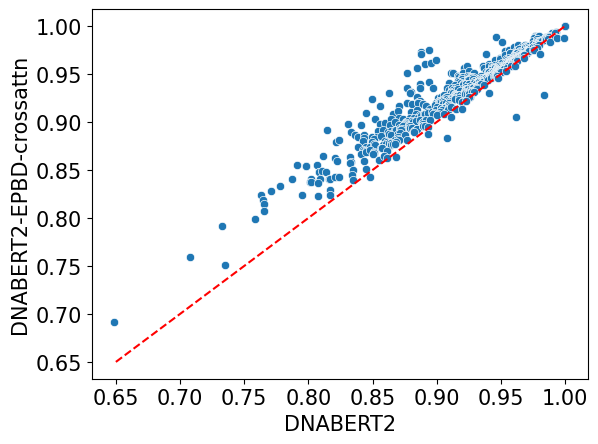

In [13]:
# change x and y axis key to get different result
# plots AUROC
sns.scatterplot(x=result_df["dnabert2_auroc"], y=result_df[f"{model_name}_auroc"])#, hue=result_df["cell"], style=result_df["cell"], palette="muted")
plt.plot([.65,1], [.65, 1], color="r", linestyle='--')
plt.ylabel("DNABERT2-EPBD-crossattn", fontsize=15)
plt.xlabel("DNABERT2", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize="x-small", title="cell")
# plt.legend().remove()
# plt.savefig(home_dir+f"analysis/figures/dnabert2_vs_dnabert2_epbd_crossattn_auroc.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
plt.show()

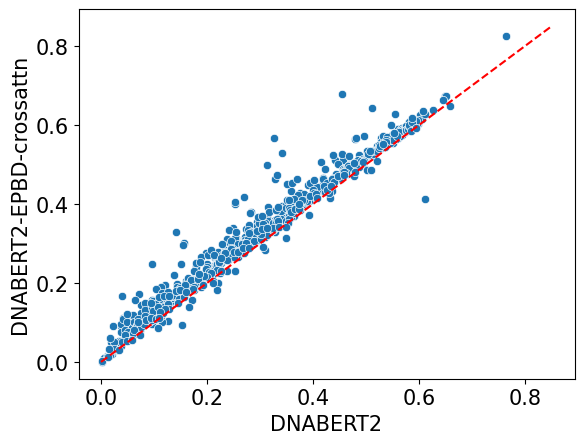

In [16]:
# plots AUPR
sns.scatterplot(x=result_df["dnabert2_aupr"], y=result_df[f"{model_name}_aupr"])#, hue=result_df["cell"], style=result_df["cell"], palette="muted")
plt.plot([0,.85], [0, .85], color="r", linestyle='--') # 
plt.ylabel("DNABERT2-EPBD-crossattn", fontsize=15)
plt.xlabel("DNABERT2", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize="x-small", title="cell")
# plt.legend().remove()
# plt.savefig(home_dir+f"analysis/figures/dnabert2_vs_dnabert2_epbd_crossattn_aupr.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
plt.show()

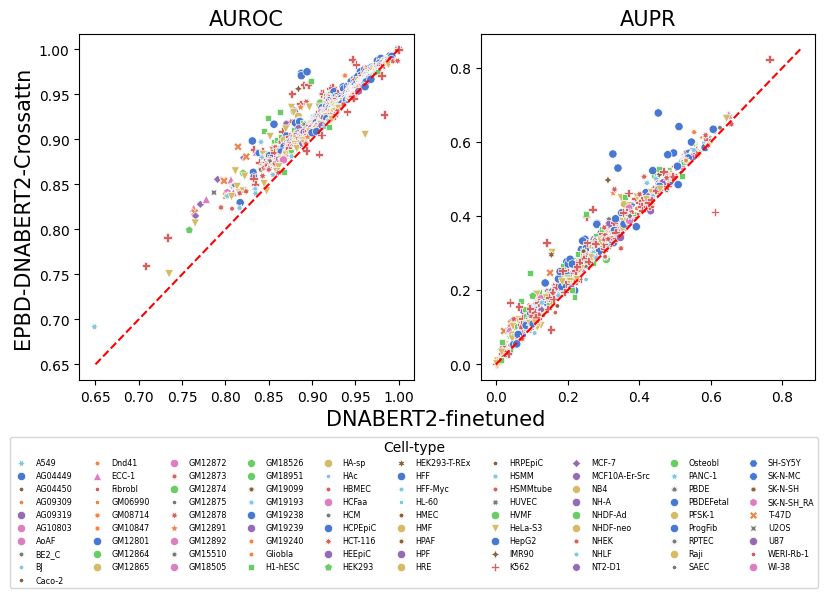

In [15]:
# not completed yet
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 4.5))

sns.scatterplot(x=result_df["dnabert2_auroc"], y=result_df[f"{model_name}_auroc"], ax=ax1, hue=result_df["cell"], style=result_df["cell"], palette="muted")
ax1.plot([.65,1], [.65, 1], color="r", linestyle='--')
ax1.legend().remove()
ax1.set_ylabel("EPBD-DNABERT2-Crossattn", fontsize=15)
ax1.set_xlabel("")#"DNABERT2")
ax1.set_title("AUROC", fontsize=15)

sns.scatterplot(x=result_df["dnabert2_aupr"], y=result_df[f"{model_name}_aupr"], ax=ax2, hue=result_df["cell"], style=result_df["cell"], palette="muted")
ax2.plot([0, .85], [0, .85], color="r", linestyle='--')
ax2.set_ylabel("")
ax2.set_xlabel("")#"DNABERT2")
ax2.set_title("AUPR", fontsize=15)

fig.text(0.5, 0.01, 'DNABERT2-finetuned', ha='center', fontsize=15)

handles, labels = ax2.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax2.legend(handles, labels, bbox_to_anchor=(-.2, -.6), loc='lower center', borderaxespad=0, fontsize="xx-small", title="Cell-type", ncols=10)

plt.savefig(home_dir+f"analysis/figures/dnabert2_vs_dnabert2_epbd_crossattn_auroc_aupr_celltypes.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [13]:
print("#-tf-binding improved (auroc):", result_df[result_df["auroc_dnabert2epbdVSdnabert2_percent"]>0].shape[0])
print("#-tf-binding improved (aupr):", result_df[result_df["aupr_dnabert2epbdVSdnabert2_percent"]>0].shape[0])

print("auroc improvements summary: ", (result_df[result_df["auroc_dnabert2epbdVSdnabert2_percent"]>0])["auroc_dnabert2epbdVSdnabert2_percent"].describe())
print("aupr improvements summary: ", (result_df[result_df["aupr_dnabert2epbdVSdnabert2_percent"]>0])["aupr_dnabert2epbdVSdnabert2_percent"].describe())

#-tf-binding improved (auroc): 665
#-tf-binding improved (aupr): 655
auroc improvements summary:  count    665.000000
mean       1.744503
std        1.835582
min        0.001000
25%        0.507598
50%        1.078210
75%        2.174166
max        9.631457
Name: auroc_dnabert2epbdVSdnabert2_percent, dtype: float64
aupr improvements summary:  count    655.000000
mean      20.277794
std       32.025984
min        0.121929
25%        4.342317
50%       11.084125
75%       22.334024
max      324.573031
Name: aupr_dnabert2epbdVSdnabert2_percent, dtype: float64


In [33]:
result_df[result_df["auroc_dnabert2epbdVSdnabert2_percent"]>0][["cell", "antibody", "auroc_dnabert2epbdVSdnabert2_percent"]].head(20)

,cell,antibody,auroc_dnabert2epbdVSdnabert2_percent
438,HepG2,MafK_(SC-477),9.631457
268,T-47D,ERalpha_a,9.477742
436,HepG2,MafF_(M8194),9.357081
437,HepG2,MafK_(ab50322),9.040995
156,H1-hESC,SRF,8.737430
230,K562,PU.1,8.445900
571,MCF-7,GATA3_(SC-269),8.166981
464,IMR90,MafK_(ab50322),8.126018
198,HepG2,SRF,8.072240
527,K562,Pol2(phosphoS2),7.930531


In [14]:
print("auroc decreased summary: ", (result_df[result_df["auroc_dnabert2epbdVSdnabert2_percent"]<=0])["auroc_dnabert2epbdVSdnabert2_percent"].describe())
print("aupr decreased summary: ", (result_df[result_df["aupr_dnabert2epbdVSdnabert2_percent"]<=0])["aupr_dnabert2epbdVSdnabert2_percent"].describe())

auroc improvements summary:  count    25.000000
mean     -0.921163
std       1.558645
min      -5.829181
25%      -0.684297
50%      -0.524230
75%      -0.121337
max       0.000000
Name: auroc_dnabert2epbdVSdnabert2_percent, dtype: float64
aupr improvements summary:  count    35.000000
mean     -9.287625
std      10.815970
min     -44.711538
25%     -11.844096
50%      -5.150843
75%      -1.814117
max      -0.021219
Name: aupr_dnabert2epbdVSdnabert2_percent, dtype: float64


In [27]:
result_df[result_df["auroc_dnabert2epbdVSdnabert2_percent"]<=0][["cell", "antibody", "auroc_dnabert2epbdVSdnabert2_percent"]]#.value_counts() # "antibody"

result_df["cell"].value_counts()
# result_df[result_df["antibody"]=="BDP1"]

cell
K562       150
GM12878     90
HepG2       77
HeLa-S3     64
H1-hESC     58
          ... 
HFF-Myc      1
HCPEpiC      1
HBMEC        1
HEEpiC       1
HFF          1
Name: count, Length: 91, dtype: int64

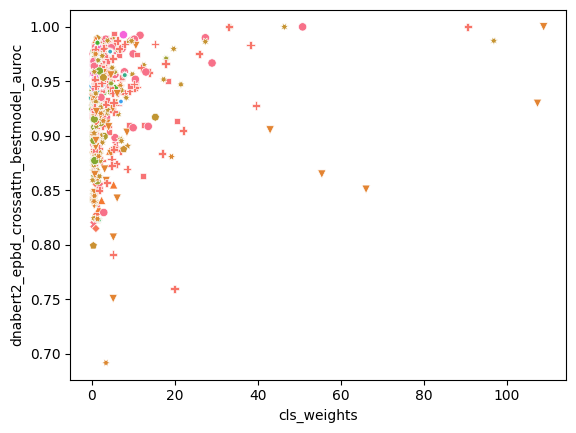

In [23]:
sns.scatterplot(x=result_df["cls_weights"], y=result_df[f"{model_name}_auroc"], hue=result_df["cell"], style=result_df["cell"])
plt.legend().remove()
plt.show()

In [23]:
merged_df[merged_df["cell"]=="K562"]["cell"].value_counts()

cell
K562    150
Name: count, dtype: int64

In [24]:
less_performed_merged_df = merged_df[merged_df[f"{model_name}_auroc"]<.85]
print(less_performed_merged_df.shape)
less_performed_merged_df[["cell"]].value_counts() # "antibody"

(33, 9)


cell        
HeLa-S3         7
A549            5
ECC-1           3
GM12878         3
K562            3
MCF-7           2
T-47D           2
HEK293          1
HEK293-T-REx    1
HUVEC           1
HepG2           1
NHEK            1
PANC-1          1
SK-N-SH_RA      1
U2OS            1
Name: count, dtype: int64

In [28]:
merged_df.columns

Index(['index', 'cell', 'antibody', 'dnabert2_epbd_crossattn_bestloss_auroc',
       'dnabert2_epbd_crossattn_bestloss_aupr', 'dnabert2_auroc',
       'dnabert2_aupr'],
      dtype='object')